In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
#from nltk import word_tokenize
from nltk.tokenize import word_tokenize
#libraries for lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
#nltk.download('all')

In [2]:
df = pd.read_csv('new_train.csv')
test_df =pd.read_csv('new_test.csv')

In [3]:
df.head()

,Unnamed: 0,Reviews,Sentiments
0,0,This doll is totallly great!: This doll is the...,1
1,1,Kellie is adorable: I picked her to win Americ...,1
2,2,Dark Desire: A Vampire Novel: This book is a r...,0
3,3,Fart farm: This book is disgraceful! It is the...,0
4,4,horrible: I am a consumer of black indie films...,0


In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
test_df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
df.shape

(10000, 2)

In [7]:
test_df.shape

(5000, 2)

In [8]:
df.head(10)

,Reviews,Sentiments
0,This doll is totallly great!: This doll is the...,1
1,Kellie is adorable: I picked her to win Americ...,1
2,Dark Desire: A Vampire Novel: This book is a r...,0
3,Fart farm: This book is disgraceful! It is the...,0
4,horrible: I am a consumer of black indie films...,0
5,"very poor video quality: Terrific programs, bu...",0
6,Enjoy Character roles: I enjoy the Suspense of...,1
7,"Beware: OMG, amazon this was a mess, only thin...",0
8,Weighs 7 lbs. lighter than many hospital scale...,0
9,George V Higgins is back on Kindle: As an admi...,1


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiments', ylabel='count'>

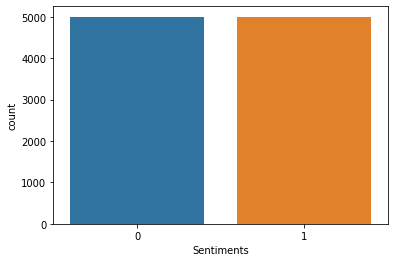

In [9]:
import seaborn as sns
sns.countplot(df.Sentiments)

In [10]:
import re
def processing(data):
  lt = WordNetLemmatizer()
  corpus = []
  for item in data:
    new_item = re.sub('[^a-zA-Z]',' ',str(item))
    new_item = new_item.lower()
    new_item = new_item.split()
    new_item = [lt.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
    corpus.append(' '.join(str(x) for x in new_item))
  return corpus

In [11]:
import time
tic=time.time()
corpus = processing(df['Reviews'])
toc = time.time()
print(f'The time taken to process the training set is :{(toc-tic)}seconds')

The time taken to process the training set is :1560.0017404556274seconds


In [12]:
import time
tic=time.time()
test_corpus = processing(test_df.Reviews)
toc = time.time()
print(f'The time taken to process the testing set is :{(toc-tic)/60}minutes')

The time taken to process the testing set is :13.540644204616546minutes


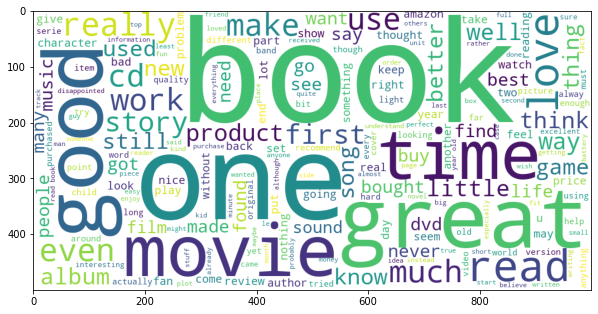

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [16]:
# Importing module
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
 
tfidf = tf_idf(ngram_range=(1,4),
          min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
          smooth_idf=1, sublinear_tf=1,analyzer='word',norm='l2')
#create a function to vectorize input texts
X =corpus
y = df.Sentiments.values

# Splitting the dataset into train and development dataset
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.30, random_state = 0)
np.save('X_train', X_train)
tf_x_train =  tfidf.fit_transform(X_train).toarray()
def transform(data):
  tf_x_train =  tfidf.fit_transform(X_train).toarray()
  vector = tfidf.transform(data).toarray()
  return vector
tf_x_dev = transform(X_dev)
print('done')

done


In [17]:
## Training the Naive Bayes, Logistic Regression, SVM, Random Forest model on the Training set
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score,  recall_score, precision_score, confusion_matrix

NB = GaussianNB()
LR = LogisticRegression(solver='sag', max_iter=1000)
RF = RandomForestClassifier()
SG = SGDClassifier(class_weight='balanced', n_jobs=-1)
LSVM = LinearSVC(class_weight='balanced')
def compare_models(X_train, X_dev, y_train, y_dev):
  #train models
  NB.fit(X_train, y_train)
  LR.fit(X_train, y_train)
  RF.fit(X_train, y_train)
  LSVM.fit(X_train, y_train)
  SG.fit(X_train, y_train)

  #predictions from each model
  y_pred_NB = NB.predict(X_dev)
  y_pred_LR = LR.predict(X_dev)
  y_pred_RF = RF.predict(X_dev)
  y_pred_LSVM = LSVM.predict(X_dev)
  y_pred_SG = SG.predict(X_dev) 

  #Model Evaluation 
  pred=[y_pred_NB, y_pred_LR, y_pred_RF, y_pred_LSVM, y_pred_SG]
  accuracy_list=[]
  recall_list = []
  precision_list =[]
  f1_list =[]


  for i in pred:
    #accuracy
    a_score = accuracy_score(y_dev, i)
    accuracy_list.append(a_score)
    #recall
    r_score = recall_score(y_dev, i)
    recall_list.append(r_score)
    #precision
    p_score = precision_score(y_dev, i)
    precision_list.append(p_score)
    #precision
    f_score = f1_score(y_dev, i)
    f1_list.append(f_score)

  #plot a metrics table
  models = ['Naive Bayes', 'Logistic Regression', 'Random Forest Classifier', 'LSVM classifier', 'SGD Classifier']
  metrics_df = pd.DataFrame({'Models':models, 'Accuracy':accuracy_list, 'Recall':recall_list, 'Precision':precision_list, 'F1 score':f1_list})
  return metrics_df
## Testing the model on test set


In [18]:
import time
tic=time.time()
models = compare_models(tf_x_train, tf_x_dev, y_train, y_dev)
toc = time.time()
print(f'The modelling time is :{(toc-tic)/60}minutes')

The modelling time is :7.7144839525222775minutes


In [20]:
models

,Models,Accuracy,Recall,Precision,F1 score
0,Naive Bayes,0.725333,0.768717,0.706388,0.736236
1,Logistic Regression,0.863667,0.861631,0.864520,0.863073
2,Random Forest Classifier,0.830667,0.833556,0.828021,0.830779
3,LSVM classifier,0.866667,0.865642,0.866801,0.866221
4,SGD Classifier,0.866333,0.866979,0.865243,0.866110


In [21]:
model= LogisticRegression()
model.fit(tf_x_train,y_train)

LogisticRegression()

In [22]:
dev_pred = model.predict(tf_x_dev)
print("Development accuracy :", accuracy_score(y_dev, dev_pred))

Development accuracy : 0.8636666666666667


In [23]:
test_set = tfidf.transform(test_corpus).toarray()
test_pred = model.predict(test_set)
print("Testing accuracy :", accuracy_score(test_df.Sentiments, test_pred))

Testing accuracy : 0.8642


In [24]:
input = [['''I really love this headset!
This is probably the best headset I've had so far because every single feature on it is great!
The audio is impeccable, the sound stays within the headset and not all over the place (which usually happens in most headphones).
The volume wheel is very easy to use and is great to move up and down smoothly.
The cable that connects from your device to the headset is amazing - although a little long for me.
I can't express though how strong and durable the cable is. I have had headsets that have a very weak wire that always breaks after a little while but the wire on this devices looks like it will last a very long time.
Last but not least, the microphone. According to my friends, I sounded much clearer when talking than my previous headsets.
Overall, I really love this headset and I would definetly recommend it! ''']]
process_input = processing(input)
vector_input = tfidf.transform(process_input)
predictions = model.predict(vector_input)
if predictions==1:
  print('Positive Review')
else:
  print('Negative Review')

Positive Review


In [25]:
import cloudpickle as pickle
import dill
file1 = open('sentiment_model.pkl', 'wb')
file2 = open('processing_function.pkl', 'wb')
file3 = open('fitted_tfidf1.pkl', 'wb')
pickle.dump(model, file1)
dill.dump(processing, file2)
dill.dump(transform, file3)
file1.close()
file2.close()
file3.close()